In [115]:
import os, sys, pickle, time
from itertools import product as p
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from tqdm import tqdm
Entrez.email = 'garycloudyang@gmail.com'
%config InlineBackend.figure_format = 'svg'

### Host Genome & CDS Download

In [72]:
df = pd.read_csv("Combined2.csv")
all_host = set(df['host'])
all_phage = set(df['phage'])
print(f"There are {len(all_host)} hosts and {len(all_phage)} phages")
print(f"Total {len(df)} pairs of interactions")

There are 369 hosts and 5446 phages
Total 5622 pairs of interactions


In [73]:
host_dir = os.path.join(os.getcwd(), 'datanew', 'host', '')

h_current = set(os.listdir(host_dir))
h_remain  = all_host - h_current
print(f"Still need to download {len(h_remain)} host")

Still need to download 10 host


In [74]:
for host in h_remain:
    try:
        handle = Entrez.efetch(db="nuccore", id=host, rettype="fasta", retmode="text")
        gene = handle.readlines()
        handle = Entrez.efetch(db="nuccore", id=host, rettype="fasta_cds_aa", retmode="text")
        aa = handle.readlines()
        sep = [i for i in range(len(aa)) if aa[i][0] == '>']
    
        host_list = [host]
        
        """ The accession might link to a master record 
            and thus need to extract individual contig's
            accession id """
        if len(aa) == 1 and len(gene) == 1:
            handle = Entrez.efetch(db="nuccore", id=host, rettype="gb", retmode="text")
            wgs = [i for i in handle.readlines() if 'WGS_SCAFLD' in i][0]
            b,e = wgs.split(' ')[2].split('-')
            for i in range(len(b)):
                if b[i] != e[i]:
                    end = i
                    break
            prefix, start, end = b[:end], b[end:], e[end:].strip()
            host_list = []
            for i in range(int(start), int(int(end) + 1)):
                suffix = "0" * int(len(end) - len(str(i)))
                suffix += str(i)
                newid = prefix + suffix
                host_list.append(newid)
                        
        for h in host_list:
            if len(host_list) != 1:
                handle = Entrez.efetch(db="nuccore", id=h, rettype="fasta", retmode="text")
                gene = handle.readlines()
                handle = Entrez.efetch(db="nuccore", id=h, rettype="fasta_cds_aa", retmode="text")
                aa = handle.readlines()
                sep = [i for i in range(len(aa)) if aa[i][0] == '>']

            """ In case the directory does not exist """
            if not os.path.isdir(host_dir + host):
                os.mkdir(host_dir + host)
                  
            """ Write genome/contigs to .fasta file """
            with open(os.path.join(host_dir + host, f'{host}.fasta') , 'a') as f:
                for i in gene:
                    f.write(i)
        
            """ In case some contigs have no CDS (only regions like rRNA) """
            if len(sep) == 0 and len(host_list) != 1:
                continue
                
            """ Write CDS amino acid """
            with open(os.path.join(host_dir + host, f'{host}.aa'), 'a') as f:
                for i in range(len(sep) - 1):
                    f.write(aa[sep[i]].split(' ')[0])
                    f.write('\n')
                    f.write(("".join(aa[sep[i]+1:sep[i+1]])).replace('\n', ''))
                    f.write('\n')
                f.write(aa[sep[-1]].split(' ')[0])
                f.write('\n')
                f.write(("".join(aa[sep[-1]+1:])).replace('\n', ''))  

        print(f"Done with {host}!")
        
    except:
        print(f"WARNING: Issue with {host}")
            
        if os.path.isdir(host_dir + host):
            for i in os.listdir(host_dir + host):
                os.remove(os.path.join(host_dir + host, i))
            os.rmdir(host_dir + host)
        
        continue

#### Summary of Problematic Hosts

In [75]:
pair = 0
for i in h_remain:
    print(f"{i} has {df[df['host'] == i].shape[0]} phages")
    pair += df[df['host'] == i].shape[0]
print(f"Missing {pair} of interactions due to hosts")

AF346474.1 has 1 phages
NZ_QLNP01000001.1 has 18 phages
NZ_CABEIC010000001.1 has 461 phages
NZ_DF968184.1 has 3 phages
MN294681.1 has 255 phages
MT645820.1 has 1 phages
NR_026488.1 has 1 phages
KU885916.2 has 1 phages
NZ_AQYI01000001.1 has 6 phages
NZ_FOQB01000027.1 has 17 phages
Missing 764 of interactions due to hosts


### Phage Genome & CDS Download

In [ ]:
phage_dir = os.path.join(os.getcwd(), 'datanew', 'phage', '')
p_current = set(os.listdir(phage_dir))
p_remain  = all_phage - p_current
p_remain = {x.strip() for x in p_remain if x==x}
print(f"Still need to download {len(p_remain)} phage")

In [ ]:
for phage in p_remain:
    try:        
        handle = Entrez.efetch(db="nuccore", id=phage, rettype="fasta", retmode="text")
        gene = handle.readlines()
        handle = Entrez.efetch(db="nuccore", id=phage, rettype="fasta_cds_aa", retmode="text")
        aa = handle.readlines()
        sep = [i for i in range(len(aa)) if aa[i][0] == '>']
    
        phage_list = [phage]
        
        """ The accession might link to a master record 
            and thus need to extract individual contig's
            accession id """
        if len(aa) == 1 and len(gene) == 1:
            handle = Entrez.efetch(db="nuccore", id=phage, rettype="gb", retmode="text")
            wgs = [i for i in handle.readlines() if 'WGS_SCAFLD' in i][0]
            b,e = wgs.split(' ')[2].split('-')
            for i in range(len(b)):
                if b[i] != e[i]:
                    end = i
                    break
            prefix, start, end = b[:end], b[end:], e[end:].strip()
            phage_list = []
            for i in range(int(start), int(int(end) + 1)):
                suffix = "0" * int(len(end) - len(str(i)))
                suffix += str(i)
                newid = prefix + suffix
                phage_list.append(newid)
                        
        for h in phage_list:
            if len(phage_list) != 1:
                handle = Entrez.efetch(db="nuccore", id=h, rettype="fasta", retmode="text")
                gene = handle.readlines()
                handle = Entrez.efetch(db="nuccore", id=h, rettype="fasta_cds_aa", retmode="text")
                aa = handle.readlines()
                sep = [i for i in range(len(aa)) if aa[i][0] == '>']

            """ In case the directory does not exist """
            if not os.path.isdir(phage_dir + phage):
                os.mkdir(phage_dir + phage)
                  
            """ Write genome/contigs to .fasta file """
            with open(os.path.join(phage_dir + phage, f'{phage}.fasta') , 'a') as f:
                for i in gene:
                    f.write(i)
        
            """ In case some contigs have no CDS (only regions like rRNA) """
            if len(sep) == 0 and len(phage_list) != 1:
                continue
                
            """ Write CDS amino acid """
            with open(os.path.join(phage_dir + phage, f'{phage}.aa'), 'a') as f:
                for i in range(len(sep) - 1):
                    f.write(aa[sep[i]].split(' ')[0])
                    f.write('\n')
                    f.write(("".join(aa[sep[i]+1:sep[i+1]])).replace('\n', ''))
                    f.write('\n')
                f.write(aa[sep[-1]].split(' ')[0])
                f.write('\n')
                f.write(("".join(aa[sep[-1]+1:])).replace('\n', ''))  

        print(f"Done with {phage}!")
    except:
        print(f"WARNING: Issue with {phage}")
            
        if os.path.isdir(phage_dir + phage):
            for i in os.listdir(phage_dir + phage):
                os.remove(os.path.join(phage_dir + phage, i))
            os.rmdir(phage_dir + phage)
        
        continue

### Check the not-downloaded HOSTS & generate a pseudo-csv for further download

In [58]:
df = pd.read_csv('Combined2.csv')
all_host = set(df['host'])
current_host = set([i for i in os.listdir(os.path.join(os.getcwd(), 'datanew', 'host'))])
mapping_to_all_host = []

for cur in current_host:
    for lib in all_host:
        if cur in lib:
            mapping_to_all_host.append(lib)

remaining_hosts = all_host - set(mapping_to_all_host)
print(len(remaining_hosts))

10


### Check the not-downloaded PHAGES & generate a pseudo-csv for further download

In [59]:
df = pd.read_csv('Combined2.csv')
all_phage = set(df['phage'])
current_phages = set([i for i in os.listdir(os.path.join(os.getcwd(), 'datanew', 'phage'))])
mapping_to_all_phage = []

for cur in current_phages:
    for lib in all_phage:
        if str(cur) in str(lib):
            mapping_to_all_phage.append(lib)
            #print("{}, {}".format(cur, lib))

remaining_phages = all_phage - set(mapping_to_all_phage)

print(len(remaining_phages))

21


### Filtered out phage-host interaction pair that does not have file downloaded

And write the available interaction pairs to a new csv file

In [60]:
df = pd.read_csv('Combined2.csv').to_numpy()

current_phages = set([i for i in os.listdir(os.path.join(os.getcwd(), 'datanew', 'phage'))])
current_hosts = set([i for i in os.listdir(os.path.join(os.getcwd(), 'datanew', 'host'))])
index = []

for i in range(df.shape[0]):
    if df[i, 1] in current_phages and df[i, 2] in mapping_to_all_host:
        index.append(i)
        
remaining = np.take(df, index, axis=0)
print(remaining)
print(remaining.shape)
l = pd.DataFrame(data=remaining[:, 1:], index=remaining[:, 0], columns=['phage', 'host'])
l.to_csv('data.csv')

[[0 'NC_026583' 'NZ_LN831039.1']
 [1 'NC_026584' 'NZ_LN831039.1']
 [2 'NC_026585' 'NZ_LN831039.1']
 ...
 [6434 'JQ965701' 'NC_017168.1']
 [6435 'NC_047939' 'NC_017168.1']
 [6436 'NC_047940' 'NC_017168.1']]
(4827, 3)


### Visualize Strain distribution 

4827 pairs of interactions
354 strains of host
201 strains with more than 1 phage
154 strains with more than 2 phage
124 strains with more than 3 phage


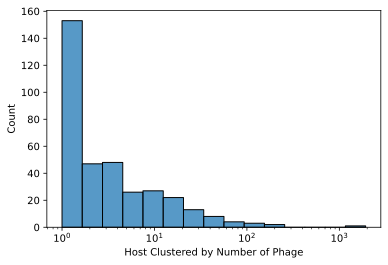

[1925, 216, 164, 113, 110, 97, 84, 78, 73, 71, 56, 52, 52, 52, 52, 38, 37, 35, 31, 30, 30, 28, 27, 26, 25, 24, 24, 23, 22, 22, 22, 20, 20, 19, 19, 18, 18, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 14, 14, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10, 10, 10, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [61]:
import seaborn as sns
a = l['host'].value_counts().to_numpy()
print(f"{len(l)} pairs of interactions")
print(f"{len(a)} strains of host")
print(f"{np.count_nonzero(a > 1)} strains with more than 1 phage")
print(f"{np.count_nonzero(a > 2)} strains with more than 2 phage")
print(f"{np.count_nonzero(a > 3)} strains with more than 3 phage")
sns.histplot(l['host'].value_counts().to_numpy(), log_scale=True)
plt.xlabel("Host Clustered by Number of Phage")
plt.show()
print(a.tolist())

In [62]:
vals = l['host'].value_counts().to_numpy()
keys = l['host'].value_counts().keys().tolist()

##### Build Host Taxonomy Summary

##### Build Helper Dictionaries
1. A dictionary with key of **accession id** and value of **the list of taxonomy string**
2. A dictionary with key of **taxon node id** and value of **corresponding taxon rank**
3. A dictionary with key of **taxon node name (many aliasing)** and value of **taxon node id**

*nodes.dmp* and *names.dmp* were downloaded from NCBI taxonomy database taxdump.tar.gz

In [65]:
""" A dictionary w/ host id as key and taxonomy as value """
with open("Host_taxonomy.csv", 'r') as f:
    lines = f.readlines()
    
taxon = {}
for l in lines:
    taxon[l.split(',')[0]] = l.split(',')[1]

In [66]:
""" A dictionary w/ taxon node id and taxon rank """
with open("taxon//nodes.dmp", "r") as f:
    lines = f.readlines()
    
taxonrank, taxonparent = {}, {}
for l in lines:
    tmp = l.split('|')
    taxonrank[tmp[0].strip()] = tmp[2].strip()
    taxonparent[tmp[0].strip()] = tmp[1].strip()

In [67]:
""" A dictionary w/ taxon node name and taxon node id """
with open("taxon//names.dmp", "r") as f:
    lines = f.readlines()

taxonid = {}
for l in lines:
    if l.split('|')[1].strip() not in taxonid:
        taxonid[l.split('|')[1].strip()] = l.split('|')[0].strip()

In [68]:
def lookup_name(num):
    names = []
    for i, j in taxonid.items():
        if j == num:
            names.append(i)
    return min(names, key=len)
    #print(f"{min(names, key = len)} has {v} pair of interaction") 

### Visualize Host Distribution Clustered by Taxon Ranks

4826 pairs of interactions (exclude hosts w/o this rank)
10 unique phylum of host
9 phylum with more than 1 phage
8 phylum with more than 2 phage
8 phylum with more than 3 phage


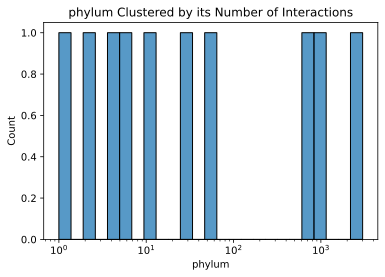

actinobacteria has 3007 interactions
Bacillota has 766 interactions
proteobacteria has 938 interactions
BCF group has 60 interactions
Cyanophyta has 32 interactions
Mollicutota has 11 interactions


In [70]:
# rank can be 'superkingdom, phylum, class, order, family, genus' 
rank = 'phylum'
lib  = {}

for k, v in taxon.items():
    exist = False
    t = v.split(';')
    for j in t:
        if taxonrank[taxonid[j.strip()]] == rank:
            exist = True
            lib[taxonid[j.strip()]] = lib.get(taxonid[j.strip()], 0) + vals[keys.index(k)]
    if not exist:
        lowest = j.strip()
        this_n = taxonid[lowest]
        parent = taxonparent[this_n]
        while this_n != parent:
            if taxonrank[parent] == rank:
                exist = True
                #name = lookup_name(parent)
                lib[parent] = lib.get(parent, 0) + vals[keys.index(k)]
                break
            this_n = parent
            parent = taxonparent[this_n]
        if not exist:
            print(f"WARNING: {k} has no expected rank: {rank}")


a = np.array([v for k, v in lib.items()])
print(f"{np.sum(a)} pairs of interactions (exclude hosts w/o this rank)")
print(f"{len(a)} unique {rank} of host")
print(f"{np.count_nonzero(a > 1)} {rank} with more than 1 phage")
print(f"{np.count_nonzero(a > 2)} {rank} with more than 2 phage")
print(f"{np.count_nonzero(a > 3)} {rank} with more than 3 phage")
#sns.histplot(a, log_scale=True, bins=20)
sns.histplot(a, log_scale=True, bins=25)
plt.title(f"{rank} Clustered by its Number of Interactions")
plt.xlabel(f"{rank}")
plt.show()
#print(a)
for k, v in lib.items():
    if v > 5:
        print(f"{lookup_name(k)} has {v} interactions")

### Generate Negative Sample

In [ ]:
# Create Random Negative Sample (For now; placeholder method)
import random

neg_df = pd.DataFrame(columns=('phage', 'host', 'species'))



for i in range(len(comb_dsets)):
    sample = random.sample(list(uniq_species), 2)
    if sample[0] == comb_dsets.iloc[i]['species']:
        neg_species = sample[1]
    else: 
        neg_species = sample[0]
    neg_host = random.sample(comb_dsets.loc[comb_dsets['species'] == neg_species]['host'].tolist(), 1)[0]
    neg_phage = comb_dsets.iloc[i]['phage']
    neg_df.loc[len(neg_df)] = [neg_phage, neg_host, neg_species]

### Encode Features

##### Amino Acid Composition & Organic Element Composition & Molecular Weight

In [ ]:
fpath = os.path.join(os.getcwd(), 'datanew', 'host', "")

for file in tqdm(os.listdir(fpath)):
    if os.path.exists(os.path.join(fpath + file, 'protein.ft')):
        continue
    
    with open(os.path.join(fpath + file, f'{file}.aa'), 'r') as f:
        print(file)
        
        lines = f.readlines()
        num_protein = len(lines) // 2
        aaft = np.zeros((num_protein, 27)) 
        aac  = np.zeros((21), dtype=np.float64)
        ac   = np.zeros((5), dtype=np.float64)

        for seq in range(num_protein):
            this_aa = lines[seq * 2 + 1]
            try:
                this_aa = this_aa.strip()
                for tmp in this_aa:
                    aac[AA.find(tmp)] += 1
                    if AA.find(tmp) == 20 or AA.find(tmp) == -1:
                        continue
                    ac += np.array(list(Chemi_stats[tmp].values()))
                aaft[seq, 0:21]  = aac / np.sum(aac)
                aaft[seq, 21:26] = ac / np.sum(ac)
                aaft[seq, -1]    = ProteinAnalysis(this_aa, monoisotopic=True).molecular_weight()
            except:
                aaft[seq, -1]    = -1

        aaft = np.delete(aaft, np.where(aaft[:, -1] == -1)[0], 0)
        
        # Check the accuracy of np.savee & np.load
        name = os.path.join(fpath + file, "protein.ft")
        np.save(name, aaft)
        reload = np.load(os.path.join(fpath + file, "protein.ft.npy"))
        assert (aaft == reload).all()
        
        
        
"""
feat = dict((''.join(i), 0) for i in p('ACGT', repeat=6))
len(feat)
"""

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.inspection import permutation_importance

In [4]:
df = pd.read_csv("full_data.csv")[['phage', 'host', 'relation']].to_numpy()
Y = df[:, 2]
info = df[:, 0:2]
X = np.zeros((info.shape[0], 27 * 4))

In [5]:
for i in range(info.shape[0]):
    p = np.load(os.path.join(os.getcwd(), "datanew", "phage", info[i, 0], "protein.ft.npy"))
    m1 = np.average(p, axis=0)
    s1 = np.std(p, axis=0)
    h = np.load(os.path.join(os.getcwd(), "datanew", "host", info[i, 1], "protein.ft.npy"))
    m2 = np.average(h, axis=0)
    s2 = np.std(h, axis=0)
    r = np.concatenate((m1, s1, m2, s2), axis=0)
    X[i, :] = r

In [6]:
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y.astype(int), test_size=0.5, random_state=42)

F1 socre is 0.810605


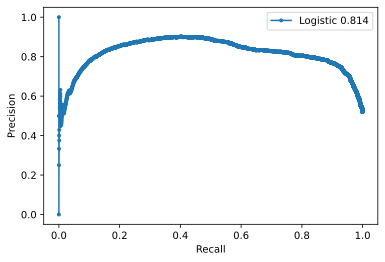

In [12]:
clf = LogisticRegression(random_state=0, max_iter=1e3, tol=1e-5, C=1).fit(X_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
plt.plot(recall, precision, marker='.', label=f"Logistic {prc:.3f}")
print(f"F1 socre is {f1:3f}")
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

F1 socre is 0.834279


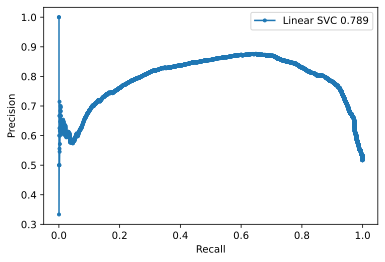

In [17]:
clf = SVC(random_state=0, kernel='linear', probability=True, cache_size=2000).fit(X_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
plt.plot(recall, precision, marker='.', label=f"Linear SVC {prc:.3f}")
print(f"F1 socre is {f1:3f}")
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

F1 socre is 0.932193


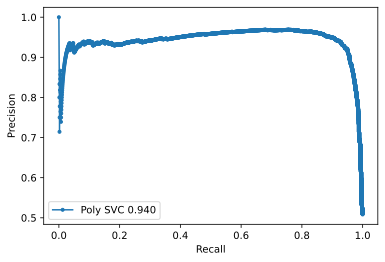

In [53]:
clf = SVC(random_state=0, kernel='poly', degree=2, C=5, probability=True, cache_size=3000).fit(X_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
plt.plot(recall, precision, marker='.', label=f"Poly SVC {prc:.3f}")
print(f"F1 socre is {f1:3f}")
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

F1 socre is 0.911428


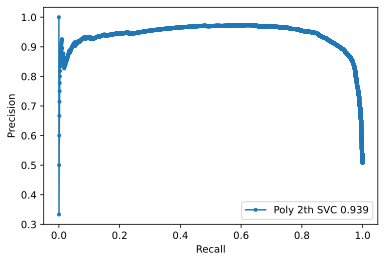

F1 socre is 0.894302


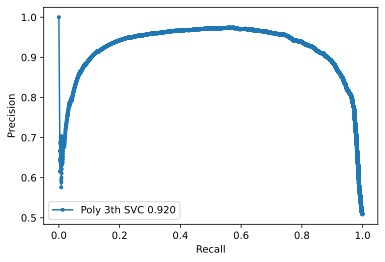

F1 socre is 0.883560


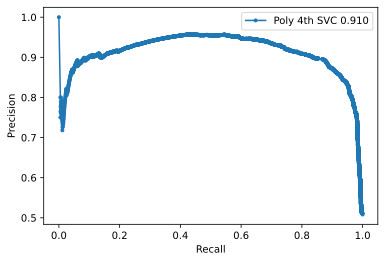

F1 socre is 0.860395


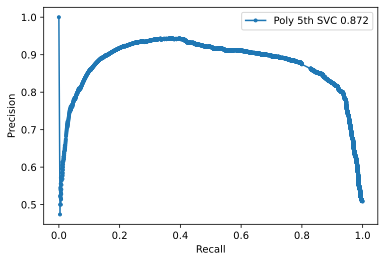

F1 socre is 0.835273


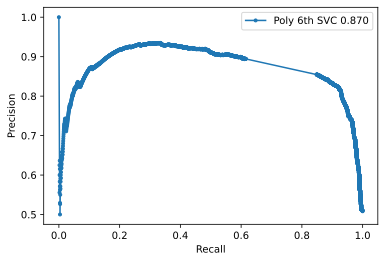

F1 socre is 0.779380


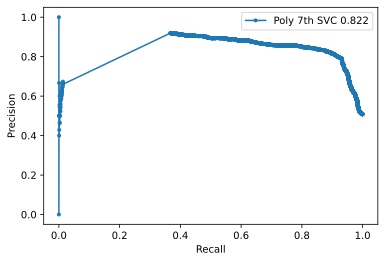

F1 socre is 0.597185


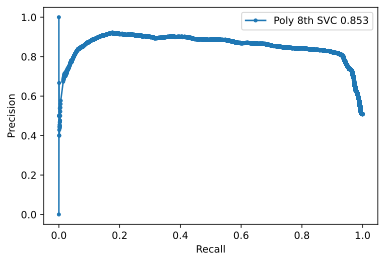

F1 socre is 0.451338


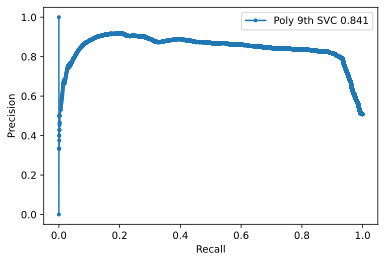

In [23]:
for i in range(2, 10):
    clf = SVC(random_state=0, kernel='poly', degree=i, probability=True, cache_size=3000).fit(X_train, y_train)
    precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
    plt.plot(recall, precision, marker='.', label=f"Poly {i}th SVC {prc:.3f}")
    print(f"F1 socre is {f1:3f}")
    plt.legend()
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.show()

F1 socre is 0.924377


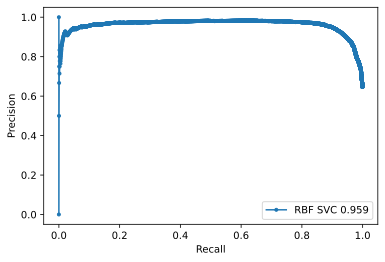

In [39]:
clf = SVC(random_state=0, kernel='rbf', C=1, probability=True, cache_size=3000).fit(X_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
plt.plot(recall, precision, marker='.', label=f"RBF SVC {prc:.3f}")
print(f"F1 socre is {f1:3f}")
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

F1 socre is 0.940329


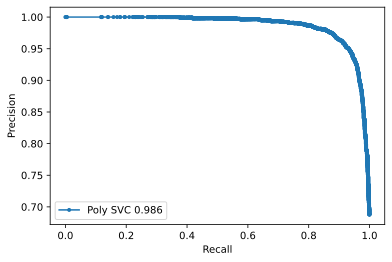

In [80]:
clf = RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42, warm_start=True, n_estimators=100, n_jobs=-1, min_samples_leaf=2).fit(X_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
plt.plot(recall, precision, marker='.', label=f"Poly SVC {prc:.3f}")
print(f"F1 socre is {f1:3f}")
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

In [186]:
c = ["AA-" + i for i in AA] + ["PC-" + i for i in PC] + ['MW']
cols = []
for i in ['P', 'H']:
    for j in ['M', 'S']:
        for k in c:
            cols.append(f"{i}-{j}-{k}")

In [ ]:
importance = pd.DataFrame(columns=cols)
for i in range(100):
    print(i)
    tmp = permutation_importance(clf, X_train, y_train, n_repeats=1, random_state=int(time.time()), n_jobs=-1)
    importance.loc[len(importance)] = tmp.importances_mean

importance

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253


In [ ]:
importance.to_csv("FeatureImportance.csv")

In [122]:
df_feature_long = pd.melt(importance,var_name='feature name', value_name='values')
df_feature_long

feature name    values
0      Phage-Mean-A  0.001036
1      Phage-Mean-A  0.001450
2      Phage-Mean-A  0.000622
3      Phage-Mean-A  0.002486
4      Phage-Mean-A  0.001036
...             ...       ...
10795   Host-Std-MW  0.000207
10796   Host-Std-MW  0.000207
10797   Host-Std-MW  0.000000
10798   Host-Std-MW  0.000000
10799   Host-Std-MW  0.000207

[10800 rows x 2 columns]

In [166]:
rank = tmp.argsort().argsort()
pal = sns.color_palette("coolwarm", len(importance))
len(importance)

100

In [ ]:
sns.set(style="whitegrid", color_codes=True)
pal = sns.color_palette("coolwarm", len(importance))
rank = data.argsort().argsort()
sns.barplot(x=tmp.index, y=data, palette=np.array(pal[::-1])[rank])

plt.show()

[Text(0, 0, 'Phage-Mean-A'),
 Text(1, 0, 'Phage-Mean-C'),
 Text(2, 0, 'Phage-Mean-D'),
 Text(3, 0, 'Phage-Mean-E'),
 Text(4, 0, 'Phage-Mean-F'),
 Text(5, 0, 'Phage-Mean-G'),
 Text(6, 0, 'Phage-Mean-H'),
 Text(7, 0, 'Phage-Mean-I'),
 Text(8, 0, 'Phage-Mean-K'),
 Text(9, 0, 'Phage-Mean-L'),
 Text(10, 0, 'Phage-Mean-M'),
 Text(11, 0, 'Phage-Mean-N'),
 Text(12, 0, 'Phage-Mean-P'),
 Text(13, 0, 'Phage-Mean-Q'),
 Text(14, 0, 'Phage-Mean-R'),
 Text(15, 0, 'Phage-Mean-S'),
 Text(16, 0, 'Phage-Mean-T'),
 Text(17, 0, 'Phage-Mean-V'),
 Text(18, 0, 'Phage-Mean-W'),
 Text(19, 0, 'Phage-Mean-Y'),
 Text(20, 0, 'Phage-Mean-*'),
 Text(21, 0, 'Phage-Mean-C'),
 Text(22, 0, 'Phage-Mean-H'),
 Text(23, 0, 'Phage-Mean-O'),
 Text(24, 0, 'Phage-Mean-N'),
 Text(25, 0, 'Phage-Mean-S'),
 Text(26, 0, 'Phage-Mean-MW'),
 Text(27, 0, 'Phage-Std-A'),
 Text(28, 0, 'Phage-Std-C'),
 Text(29, 0, 'Phage-Std-D'),
 Text(30, 0, 'Phage-Std-E'),
 Text(31, 0, 'Phage-Std-F'),
 Text(32, 0, 'Phage-Std-G'),
 Text(33, 0, 'Phage-Std-H

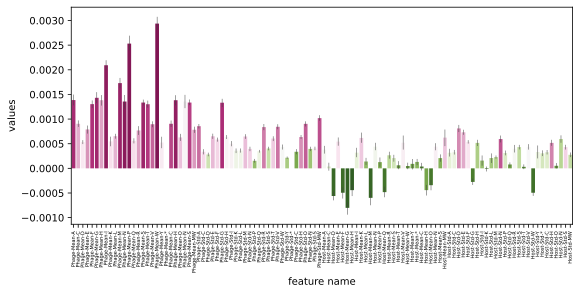

In [182]:
# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
tmp = importance.sum(axis=0)
fig, ax = plt.subplots(figsize=(9, 4))
pal = sns.color_palette("PiYG", len(tmp))
rank = tmp.argsort().argsort()
b = sns.barplot(x="feature name", y="values", data=df_feature_long, order=tmp.index, palette=np.array(pal[::-1])[rank], errwidth=0.5)
b.set_xticklabels(b.get_xticklabels(), rotation = 90, size=5)
#tmp.plot(kind='bar', figsize=(10, 4), fontsize=4, colormap='bwr')

<AxesSubplot:xlabel='values', ylabel='feature name'>

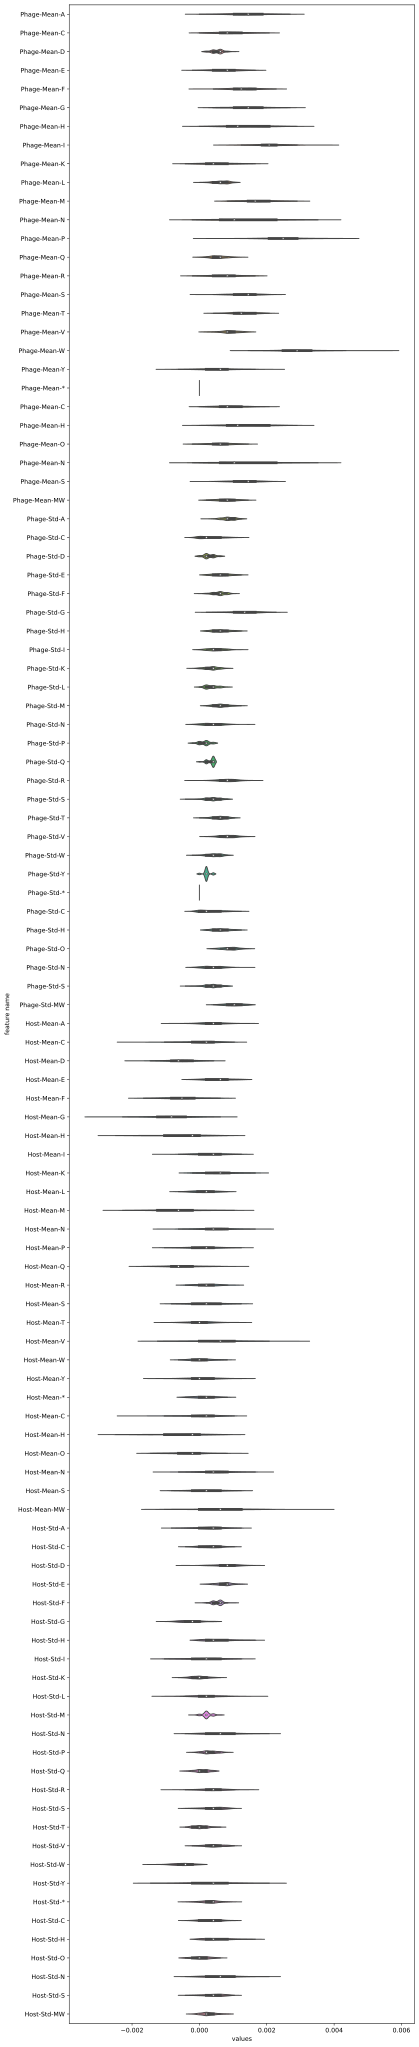

In [151]:
fig, ax = plt.subplots(figsize=(10, 60))
sns.violinplot(y="feature name", x="values", data=df_feature_long, order=tmp.index)

In [89]:
table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_', 
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W', 
        } 
AA = 'ACDEFGHIKLMNPQRSTVWY*'
print(len(AA))
print(AA.find('*'))

Chemi_stats = {    'A':{'C': 3, 'H': 7, 'O': 2, 'N': 1, 'S': 0},
                   'C':{'C': 3, 'H': 7, 'O': 2, 'N': 1, 'S': 1},
                   'D':{'C': 4, 'H': 7, 'O': 4, 'N': 1, 'S': 0},
                   'E':{'C': 5, 'H': 9, 'O': 4, 'N': 1, 'S': 0},
                   'F':{'C': 9, 'H': 11,'O': 2, 'N': 1, 'S': 0},
                   'G':{'C': 2, 'H': 5, 'O': 2, 'N': 1, 'S': 0},
                   'H':{'C': 6, 'H': 9, 'O': 2, 'N': 3, 'S': 0},
                   'I':{'C': 6, 'H': 13,'O': 2, 'N': 1, 'S': 0},
                   'K':{'C': 6, 'H': 14,'O': 2, 'N': 2, 'S': 0},
                   'L':{'C': 6, 'H': 13,'O': 2, 'N': 1, 'S': 0},
                   'M':{'C': 5, 'H': 11,'O': 2, 'N': 1, 'S': 1},
                   'N':{'C': 4, 'H': 8, 'O': 3, 'N': 2, 'S': 0},
                   'P':{'C': 5, 'H': 9, 'O': 2, 'N': 1, 'S': 0},
                   'Q':{'C': 5, 'H': 10,'O': 3, 'N': 2, 'S': 0},
                   'R':{'C': 6, 'H': 14,'O': 2, 'N': 4, 'S': 0},
                   'S':{'C': 3, 'H': 7, 'O': 3, 'N': 1, 'S': 0},
                   'T':{'C': 4, 'H': 9, 'O': 3, 'N': 1, 'S': 0},
                   'V':{'C': 5, 'H': 11,'O': 2, 'N': 1, 'S': 0},
                   'W':{'C': 11,'H': 12,'O': 2, 'N': 2, 'S': 0},
                   'Y':{'C': 9, 'H': 11,'O': 3, 'N': 1, 'S': 0}
            }
PC = 'CHONS'

inv_table = {v: k for k, v in table.items()}


21
20


In [ ]:
a = np.load(os.path.join(os.getcwd(), "datanew", "phage", "NC_049940", "protein.ft.npy"))
sum(a[0, :21])